In [18]:
import matplotlib.pyplot as plt
import matplotlib
import sys, random
import ndreg
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import skimage
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

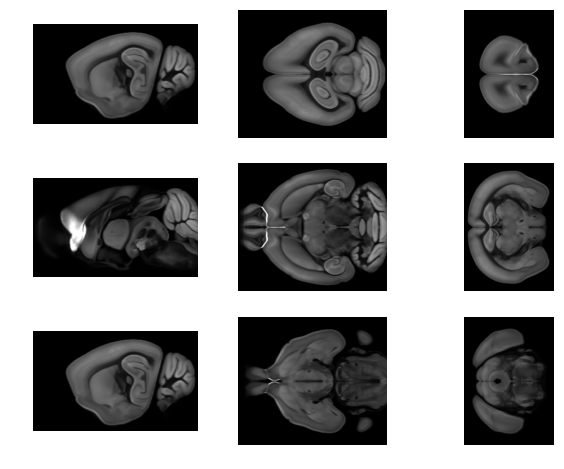

In [22]:
rmt = BossRemote(cfg_file_or_dict='./intern.cfg')
atlas = ndreg.download_ara(rmt, 50)
ndreg.imgShow(atlas)

In [23]:
full_atlas_mask = preprocessor.create_mask(atlas, use_triangle=True)

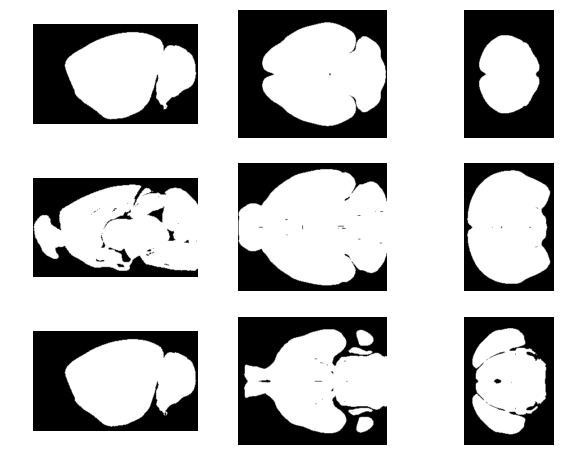

In [24]:
ndreg.imgShow(full_atlas_mask, vmax=1)

In [6]:
width, height, depth = full_atlas_mask.GetWidth(), full_atlas_mask.GetHeight(), full_atlas_mask.GetDepth()
print('width: {}\nheight: {}\ndepth: {}'.format(
        width, 
        height, 
        depth)
     )

width: 264
height: 160
depth: 228


# Mask with random hyperplane

In [7]:
def random_point(max_height, max_width):
    return random.randint(0, max_height), random.randint(0,max_width)

def random_hyperplane(height, width):
    y_1, x_1 = random_point(height, width)
    y_2, x_2 = random_point(height, width)
    m = (y_2-y_1)/(x_2-x_1)
    b = y_2 - m*x_2
    side_of_the_force = 'light' if random.randint(0,1) == 1 else 'dark'
    missing_data_mask = np.ones((height,width)) if side_of_the_force == 'light' else np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            if i - m*j <= b:
                if side_of_the_force == 'light':
                    missing_data_mask[i,j] = 0
                else:
                    missing_data_mask[i,j] = 1
            else:
                break
    return missing_data_mask

def sync_metadata(img, target):
    img = img.astype('uint16')
    img = sitk.GetImageFromArray(img)
    img.SetSpacing(target.GetSpacing())
    return img

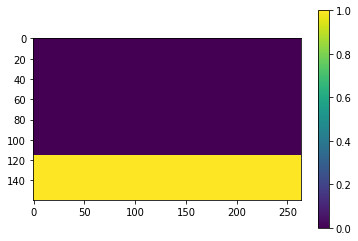

In [8]:
# Compute the hyperplane
missing_data_mask_slice = random_hyperplane(height, width)
plt.imshow(missing_data_mask_slice)
plt.colorbar()
plt.show()

In [9]:
missing_data_mask = np.zeros((depth, height, width))
for z in range(depth):
    missing_data_mask[z,:,:] = missing_data_mask_slice
missing_data_mask = sync_metadata(missing_data_mask, atlas)
# missing_data_mask = missing_data_mask.astype('uint16')
# missing_data_mask = sitk.GetImageFromArray(missing_data_mask)
# missing_data_mask.SetSpacing(atlas.GetSpacing())

In [10]:
assert missing_data_mask.GetSize() == atlas.GetSize()
assert missing_data_mask.GetPixelIDTypeAsString() == atlas.GetPixelIDTypeAsString()
assert missing_data_mask.GetSpacing() == atlas.GetSpacing()

In [20]:
masked_atlas = sitk.Mask(atlas, missing_data_mask)

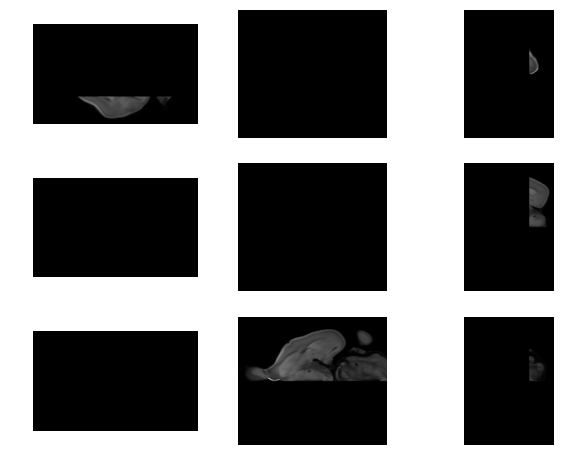

In [21]:
ndreg.imgShow(masked_atlas)

# Mask half of hemisphere

In [1]:
def image_halfspace(depth, height, width, side=False, vertical=False):
    height_lim = height//2 if not vertical else height
    width_lim = width//2 if vertical else width
    depth_lim = depth//2
    side_of_the_force = 'light' if not side else 'dark'
    missing_data_mask = np.ones((height,width)) if side_of_the_force == 'light' else np.zeros((height, width))
    for i in range(height_lim):
        for j in range(width_lim):
            if side_of_the_force == 'light':
                    missing_data_mask[i,j] = 0
            else:
                missing_data_mask[i,j] = 1
    return missing_data_mask

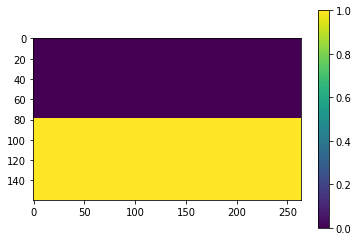

In [13]:
# Compute the hyperplane
missing_data_mask_slice = image_halfspace(height, width, vertical=False)
plt.imshow(missing_data_mask_slice)
plt.colorbar()
plt.show()

In [25]:
missing_data_mask_slice = np.ones((height,width))

In [26]:
missing_data_mask = np.zeros((depth, height, width))
for z in range(depth//2):
    missing_data_mask[z,:,:] = missing_data_mask_slice
missing_data_mask = sync_metadata(missing_data_mask, atlas)

In [27]:
assert missing_data_mask.GetSize() == atlas.GetSize()
assert missing_data_mask.GetPixelIDTypeAsString() == atlas.GetPixelIDTypeAsString()
assert missing_data_mask.GetSpacing() == atlas.GetSpacing()

In [28]:
masked_atlas = sitk.Mask(atlas, missing_data_mask)

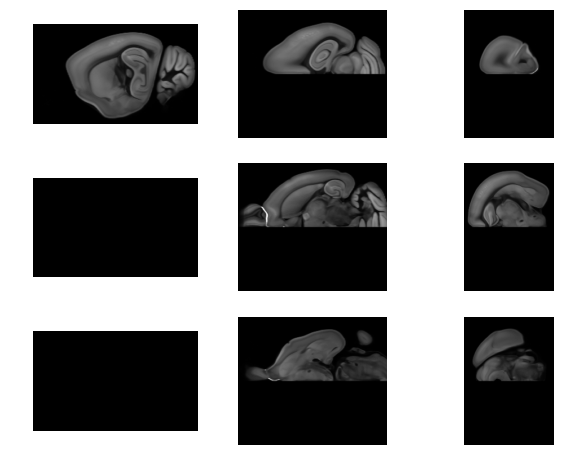

In [29]:
ndreg.imgShow(masked_atlas)

# Removing Olfactory Bulb

In [18]:
annotations = ndreg.download_ara(rmt, 50, type='annotation')
annotations_array = sitk.GetArrayFromImage(annotations)
clr_annotations_array = np.zeros((depth, height, width, 4))

## View the annotations

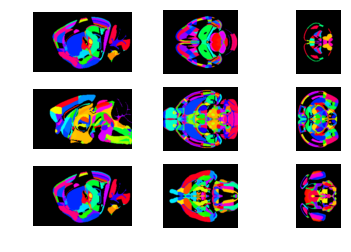

In [19]:
from matplotlib import cm
img = annotations
fig = plt.figure()
stats = sitk.StatisticsImageFilter()
labels_range = [1,-26]
cmap = 'hsv'
numSlices = 3
size = img.GetSize()
for i in range(img.GetDimension()):
    start = size[2 - i] / (numSlices + 1)
    sliceList = np.linspace(start, size[2 - i] - start, numSlices)
    sliceSize = list(size)
    sliceSize[2 - i] = 0

    for (j, slice) in enumerate(sliceList):
        sliceIndex = [0] * img.GetDimension()
        sliceIndex[2 - i] = int(slice)
        sliceImg = sitk.Extract(img, sliceSize, sliceIndex)
        sliceArray = sitk.GetArrayFromImage(sliceImg)
        labels = np.unique(sliceArray)[labels_range[0]:labels_range[1]]
        vmin = min(labels)
        vmax = max(labels)
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        
        clr_slice_array = np.zeros(tuple(list(sliceArray.shape)+[4]))
        for v in labels:
            clr = mapper.to_rgba(v)
            clr_slice_array[np.where(sliceArray == v)] = clr
        clr_slice_array[np.where(sliceArray < labels[0])] = (0.0,0.0,0.0,1.0)
        clr_slice_array[np.where(sliceArray > labels[-1])] = (0.0,0.0,0.0,1.0)

        plt.subplot(numSlices, img.GetDimension(),
                 i + img.GetDimension() * j + 1)
        ax = plt.imshow(clr_slice_array, interpolation='bilinear')
        plt.axis('off')

plt.show()

In [2]:
missing_data_array = np.copy(sitk.GetArrayFromImage(full_atlas_mask))
olfactory_bulb_layers = [658]
for layer in olfactory_bulb_layers:
    missing_data_array[np.where(annotations_array == layer)] = 0
missing_data_mask = sync_metadata(missing_data_array, atlas)
ndreg.imgShow(missing_data_mask)

NameError: name 'np' is not defined

In [22]:
masked_atlas = sitk.Mask(atlas, missing_data_mask)

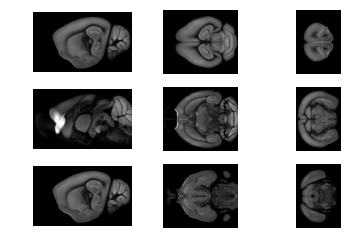

In [23]:
ndreg.imgShow(masked_atlas)

In [5]:
x = np.zeros((1,1))
type(x) == np.ndarray

True